In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # to use operating system dependent functionality
import librosa # to extract speech features
import wave # read and write WAV files
import matplotlib.pyplot as plt # to generate the visualizations

# MLP Classifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# LSTM Classifier
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
from keras.optimizer_v1 import rmsprop

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def extract_mfcc(wav_file_name):
    #This function extracts mfcc features and obtain the mean of each dimension
    #Input : path_to_wav_file
    #Output: mfcc_features'''
    y, sr = librosa.load(wav_file_name)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    
    return mfccs

In [5]:
##### load radvess speech data #####
radvess_speech_labels = [] # to save extracted label/file
ravdess_speech_data = [] # to save extracted features/file
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/ravdess-emotional-speech-audio/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        radvess_speech_labels.append(int(filename[7:8]) - 1) # the index 7 and 8 of the file name represent the emotion label
        wav_file_name = os.path.join(dirname, filename)
        ravdess_speech_data.append(extract_mfcc(wav_file_name)) # extract MFCC features/file
        
print("Finish Loading the Dataset")

Finish Loading the Dataset


In [8]:
#### convert data and label to array
ravdess_speech_data_array = np.asarray(ravdess_speech_data) # convert the input to an array
ravdess_speech_label_array = np.array(radvess_speech_labels)
ravdess_speech_label_array.shape # get tuple of array dimensions

#### make categorical labels
labels_categorical = to_categorical(ravdess_speech_label_array) # converts a class vector (integers) to binary class matrix
labels_categorical.shape

(2880, 8)

In [9]:
ravdess_speech_data_array.shape

(2880, 40)

In [8]:
x_train,x_test,y_train,y_test= train_test_split(np.array(ravdess_speech_data_array),labels_categorical, test_size=0.20, random_state=9)

In [10]:
# Split the training, validating, and testing sets
number_of_samples = ravdess_speech_data_array.shape[0]
training_samples = int(number_of_samples * 0.8)
validation_samples = int(number_of_samples * 0.1)
test_samples = int(number_of_samples * 0.1)

In [11]:
# Define the LSTM model
def create_model_LSTM():
    model = Sequential()
    model.add(LSTM(128, return_sequences=False, input_shape=(40, 1)))
    model.add(Dense(64))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(32))
    model.add(Dropout(0.4))
    model.add(Activation('relu'))
    model.add(Dense(8))
    model.add(Activation('softmax'))
    
    # Configures the model for training
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [12]:
w = np.expand_dims(ravdess_speech_data_array[:training_samples],-1)

In [13]:
w.shape

(2304, 40, 1)

In [14]:
### train using LSTM model
model_A = create_model_LSTM()
history = model_A.fit(np.expand_dims(ravdess_speech_data_array[:training_samples],-1), labels_categorical[:training_samples], validation_data=(np.expand_dims(ravdess_speech_data_array[training_samples:training_samples+validation_samples], -1), labels_categorical[training_samples:training_samples+validation_samples]), epochs=121, shuffle=True)

Epoch 1/121
72/72 [==============================] - 22s 16ms/step - loss: 2.0729 - accuracy: 0.1572 - val_loss: 2.0343 - val_accuracy: 0.2188
Epoch 2/121
72/72 [==============================] - 0s 6ms/step - loss: 2.0383 - accuracy: 0.1805 - val_loss: 1.9747 - val_accuracy: 0.2743
Epoch 3/121
72/72 [==============================] - 0s 5ms/step - loss: 1.9831 - accuracy: 0.2369 - val_loss: 1.9378 - val_accuracy: 0.2500
Epoch 4/121
72/72 [==============================] - 0s 5ms/step - loss: 1.9383 - accuracy: 0.2566 - val_loss: 1.9181 - val_accuracy: 0.2812
Epoch 5/121
72/72 [==============================] - 0s 5ms/step - loss: 1.9344 - accuracy: 0.2466 - val_loss: 1.8763 - val_accuracy: 0.2361
Epoch 6/121
72/72 [==============================] - 0s 5ms/step - loss: 1.9038 - accuracy: 0.2543 - val_loss: 1.7957 - val_accuracy: 0.3403
Epoch 7/121
72/72 [==============================] - 0s 6ms/step - loss: 1.8508 - accuracy: 0.2904 - val_loss: 1.9439 - val_accuracy: 0.2257
Epoch 8/121

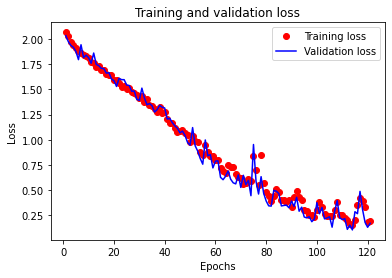

In [15]:
### loss plots using LSTM model
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

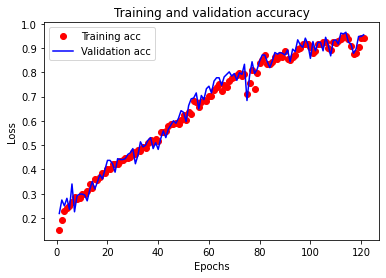

In [16]:
### accuracy plots using LSTM model
plt.clf()                                                

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [17]:
### evaluate using model A
model_A.evaluate(np.expand_dims(ravdess_speech_data_array[training_samples + validation_samples:], -1), labels_categorical[training_samples + validation_samples:])

9/9 [==============================] - 0s 3ms/step - loss: 0.1405 - accuracy: 0.9479


[0.1405143141746521, 0.9479166865348816]

In [18]:
emotions={1 : 'neutral', 2 : 'calm', 3 : 'happy', 4 : 'sad', 5 : 'angry', 6 : 'fearful', 7 : 'disgust', 8 : 'surprised'}
def predict(wav_filepath):
  test_point=extract_mfcc(wav_filepath)
  test_point=np.reshape(test_point,newshape=(1,40,1))
  predictions=model_A.predict(test_point)
  print(emotions[np.argmax(predictions[0])+1])

In [19]:
predict('/content/drive/MyDrive/Colab Notebooks/ravdess-emotional-speech-audio/Actor_02/03-01-01-01-01-01-02.wav')

neutral


In [20]:
predict('/content/drive/MyDrive/test.wav')

calm


In [25]:
predict('/content/drive/MyDrive/Colab Notebooks/ravdess-emotional-speech-audio/Actor_01/03-01-08-01-01-02-01.wav')

surprised


In [30]:
model_A.save('mymodel.h5')

In [27]:
modelc=tf.keras.models.load_model('mymodel.h5')

In [28]:
predict('/akhil.wav')

happy


In [29]:
predict('/vd.wav')

angry
